#### Step 1 导入相关包

In [1]:
import numpy as np
import pandas as pd
import pickle
from itertools import combinations
from collections import defaultdict

import matplotlib.pyplot as plt
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

#### Step 2 加载数据

In [2]:
with open('./semantics_data/patent_entity.pickle','rb') as file:
    patent_affiliation_entity = pickle.load(file)

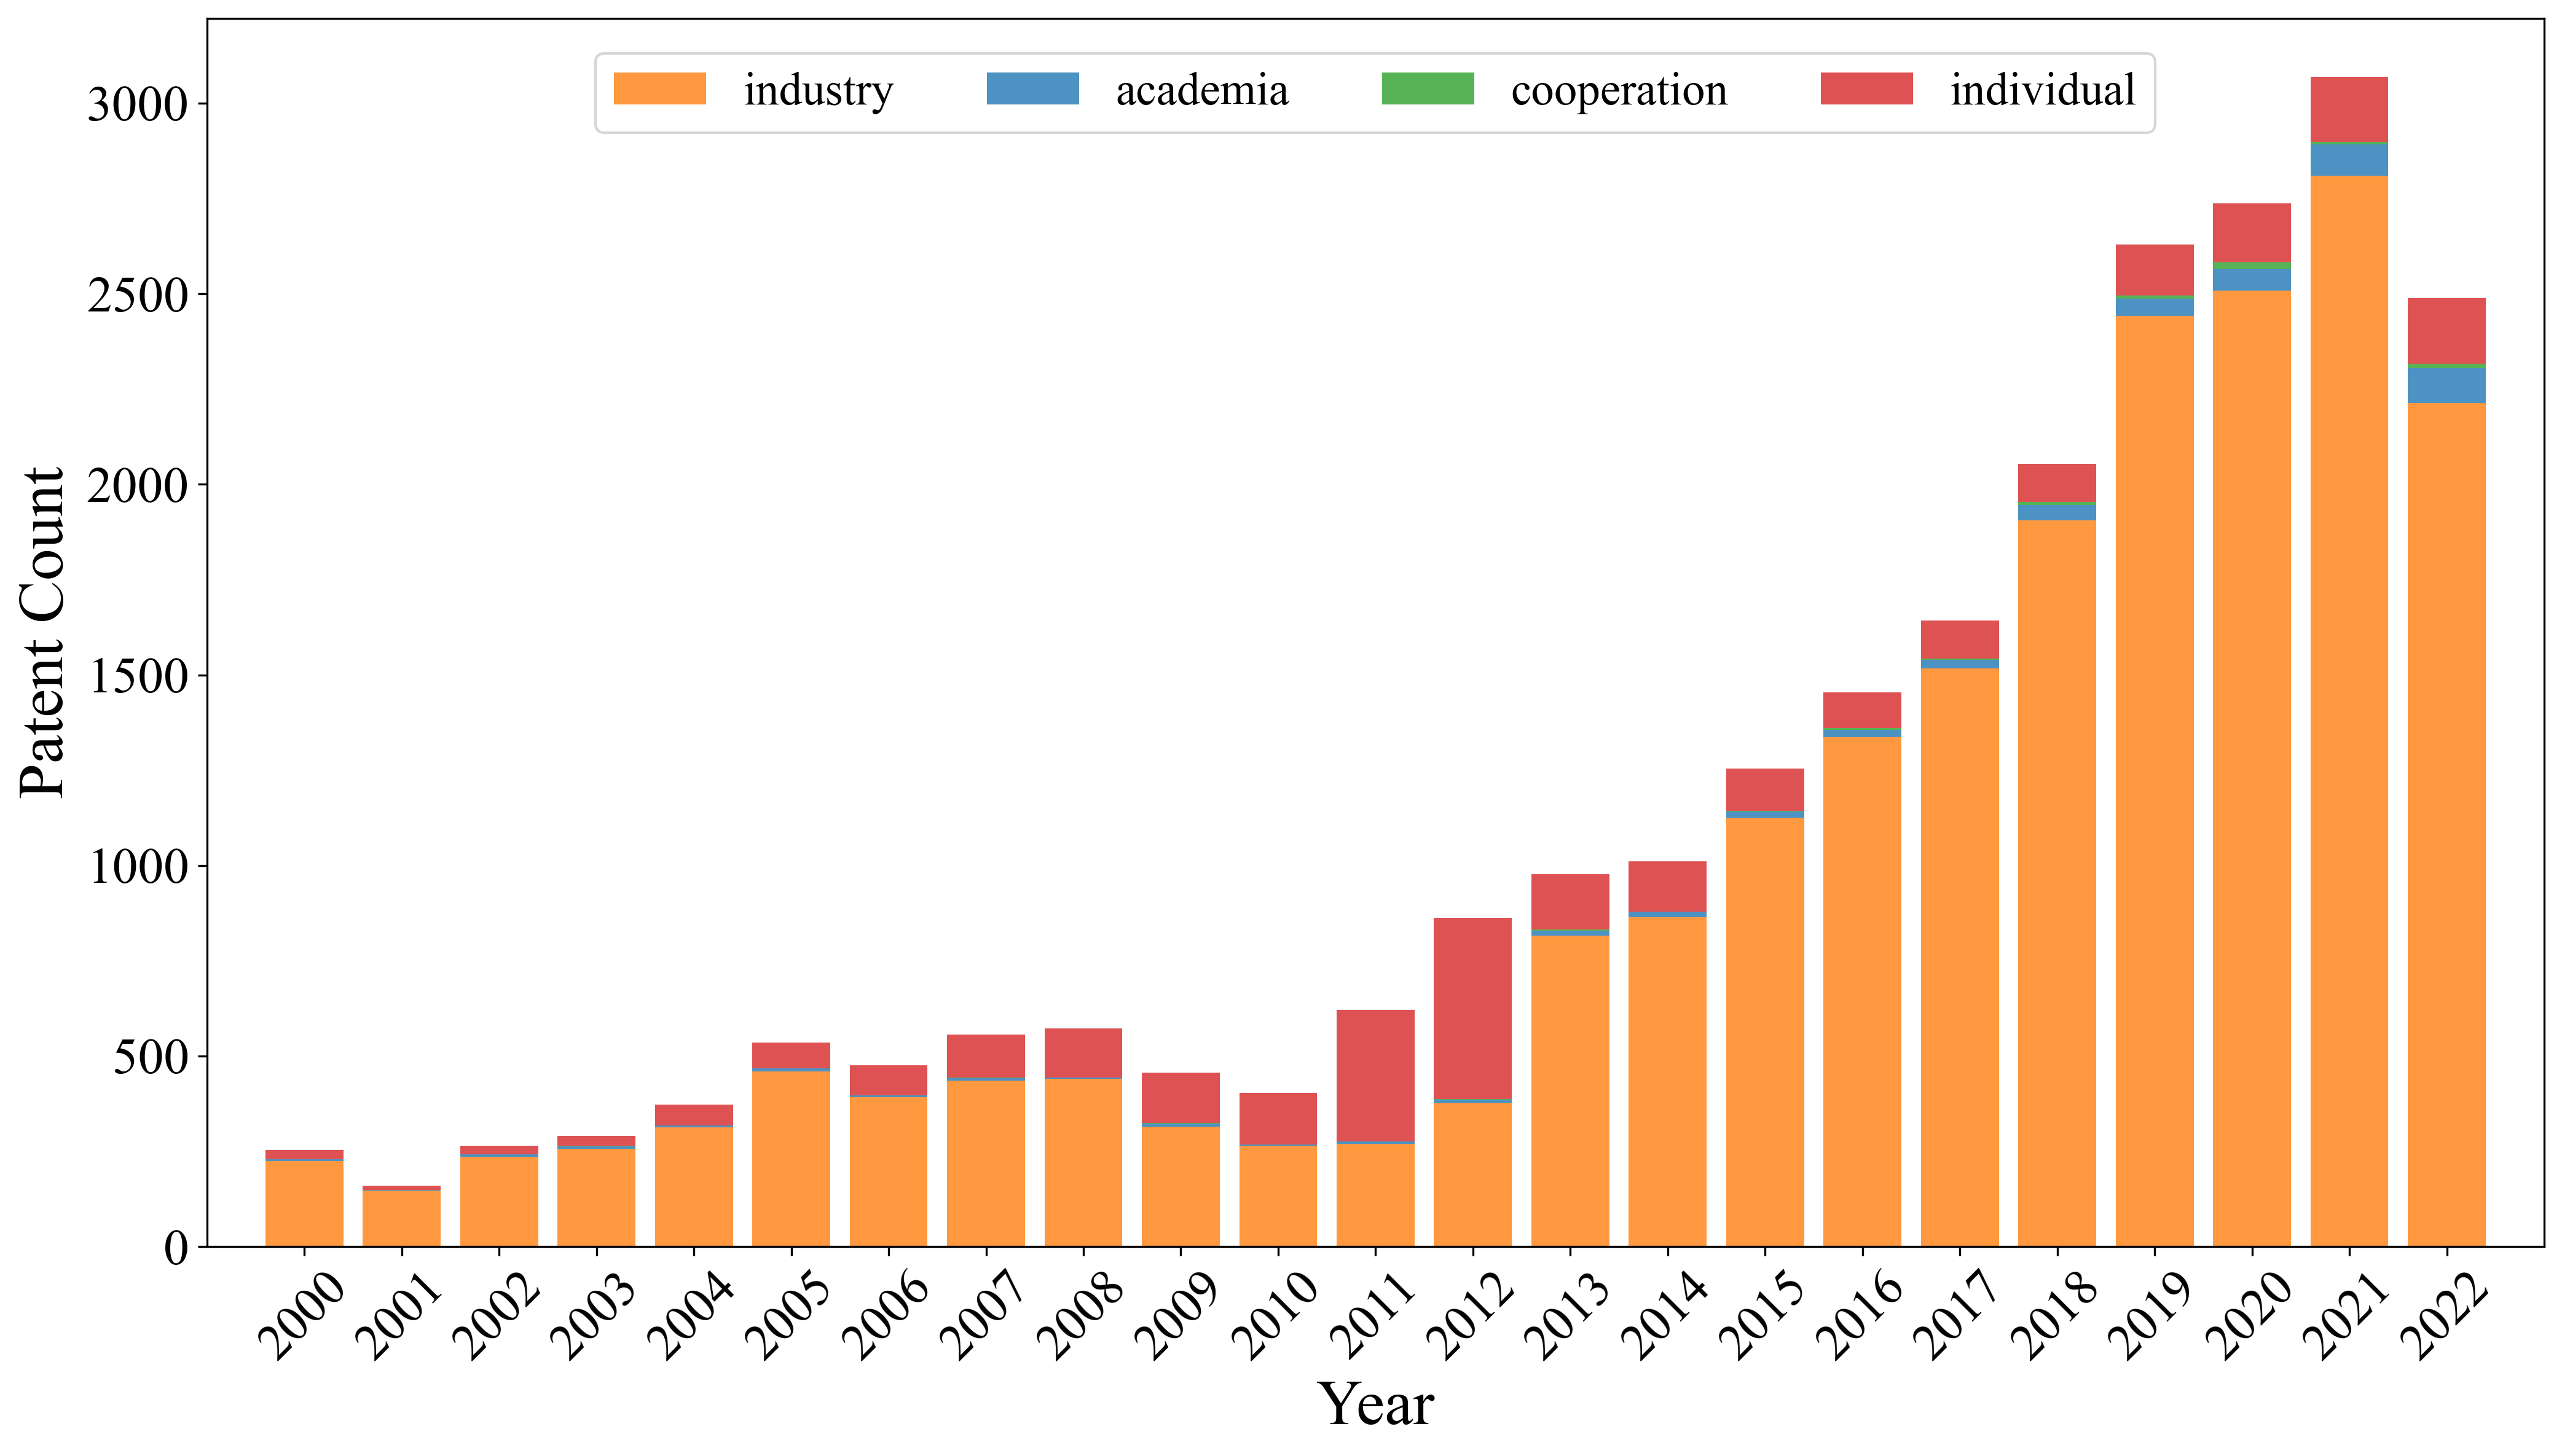

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

# 创建一个空的列表来存储每个专利的年份和合作类型
records = []

# 遍历数据并提取年份和合作类型
for patent_id, patent_info in patent_affiliation_entity.items():
    if not patent_id.startswith('US'):
        continue
    year = patent_info['year']
    cooperation_type = patent_info['Cooperation type']
    records.append({'year': year, 'cooperation_type': cooperation_type})

# 将列表转换为 DataFrame
df = pd.DataFrame(records)

# 统计每年各个合作类型的数量
df_counts = df.groupby(['year', 'cooperation_type']).size().unstack(fill_value=0)

# 修改：确保“other”标签改为“individual”
df_counts = df_counts.rename(columns={'other': 'individual','academic': 'academia'})

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

# 设置图形大小和分辨率
plt.figure(figsize=(14, 8), dpi=300)

# 使用四种颜色的配色方案，并确保industry在最底部
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ff7f0e','#1f77b4', '#2ca02c','#d62728'])

# 获取所有年份
years = df_counts.index

# 绘制每种合作类型的堆叠柱状图
bottom_values = [0] * len(years)  # 初始化底部值，用于堆叠
labels = df_counts.columns  # 合作类型标签

# 遍历每个合作类型标签并绘制堆叠柱状图
for i, label in enumerate(['industry','academia','cooperation','individual']):
    # 获取每年该合作类型的数量
    counts = df_counts[label]
    
    # 绘制柱状图
    plt.bar(years, counts, bottom=bottom_values, label=label, alpha=0.8)
    
    # 更新底部值
    bottom_values = [bottom + count for bottom, count in zip(bottom_values, counts)]

# 设置坐标轴标签和字体大小
plt.xlabel('Year', fontsize=25)
plt.ylabel('Patent Count', fontsize=25)

# 设置y轴刻度
plt.yticks(fontsize=20)
plt.xticks(years, rotation=45, fontsize=20)

# 设置图例
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4, fontsize=18)

# 设置x轴范围
plt.xlim(min(years) - 1, max(years) + 1)

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [4]:
with open('./semantics_data/patent_entity_combinations_similarity.pickle','rb') as file:
    patent_entity_combinations_similarity = pickle.load(file)

In [5]:
with open('./result/patent_cooperation_dict.pickle','rb') as file:
    patent_cooperation_dict = pickle.load(file)

In [6]:
for patent_id, data in patent_affiliation_entity.items():
    # 获取新的合作类型，若没有则保留原来的类型
    new_cooperation_type = patent_cooperation_dict.get(patent_id, data.get('Cooperation type', None))
    
    # 替换字典中的 'Cooperation type'
    data['Cooperation type'] = new_cooperation_type

#### Step 3 计算实体组合的新颖性

In [7]:
# 初始化存储每个专利中实体组合概率的 defaultdict
patent_entity_combinations_probabilities = defaultdict(list)

# 遍历每个专利，构建当前窗口的实体组合
for patent_id, entity_data in tqdm(patent_affiliation_entity.items()):
    if not patent_id.startswith('US'):
        continue

    # 提取每种实体类型的实体列表并合并到一个总列表中，并将所有实体转换为小写
    all_entities = []
    # 只算method
    for entity_type in ['Method', 'Tool', 'Dataset']:

        entity_list = entity_data.get(entity_type, [])
        
        for entity in entity_list:
            if entity:  # 如果 entity 不是空字符串
                cleaned_entity = entity.strip().strip('()')
                all_entities.append(cleaned_entity.split('(')[0].strip().lower())
    
    if len(all_entities) <= 2:
        continue

    # 计算每个专利中所有实体的两两组合并计算其概率
    for entity_pair in combinations(all_entities, 2):
        sorted_pair = tuple(sorted(entity_pair))
        
        # 查找组合的相似度
        if sorted_pair in patent_entity_combinations_similarity:
            similarity = patent_entity_combinations_similarity[sorted_pair]['similarity']
        else:
            print(f'出错了: {sorted_pair}')

        # 存储该专利的实体组合及其概率
        # 排除一个实体的情况
        if similarity>0.9999:
            continue
        patent_entity_combinations_probabilities[patent_id].append(1 - similarity)

100%|██████████| 30270/30270 [00:14<00:00, 2036.67it/s]


In [8]:
similarities = [similarity for values in patent_entity_combinations_probabilities.values() for similarity in values]

ninetenth_percentile = np.percentile(similarities, 90)

print(f"90th percentile of similarities: {ninetenth_percentile:.4f}")

90th percentile of similarities: 0.4114


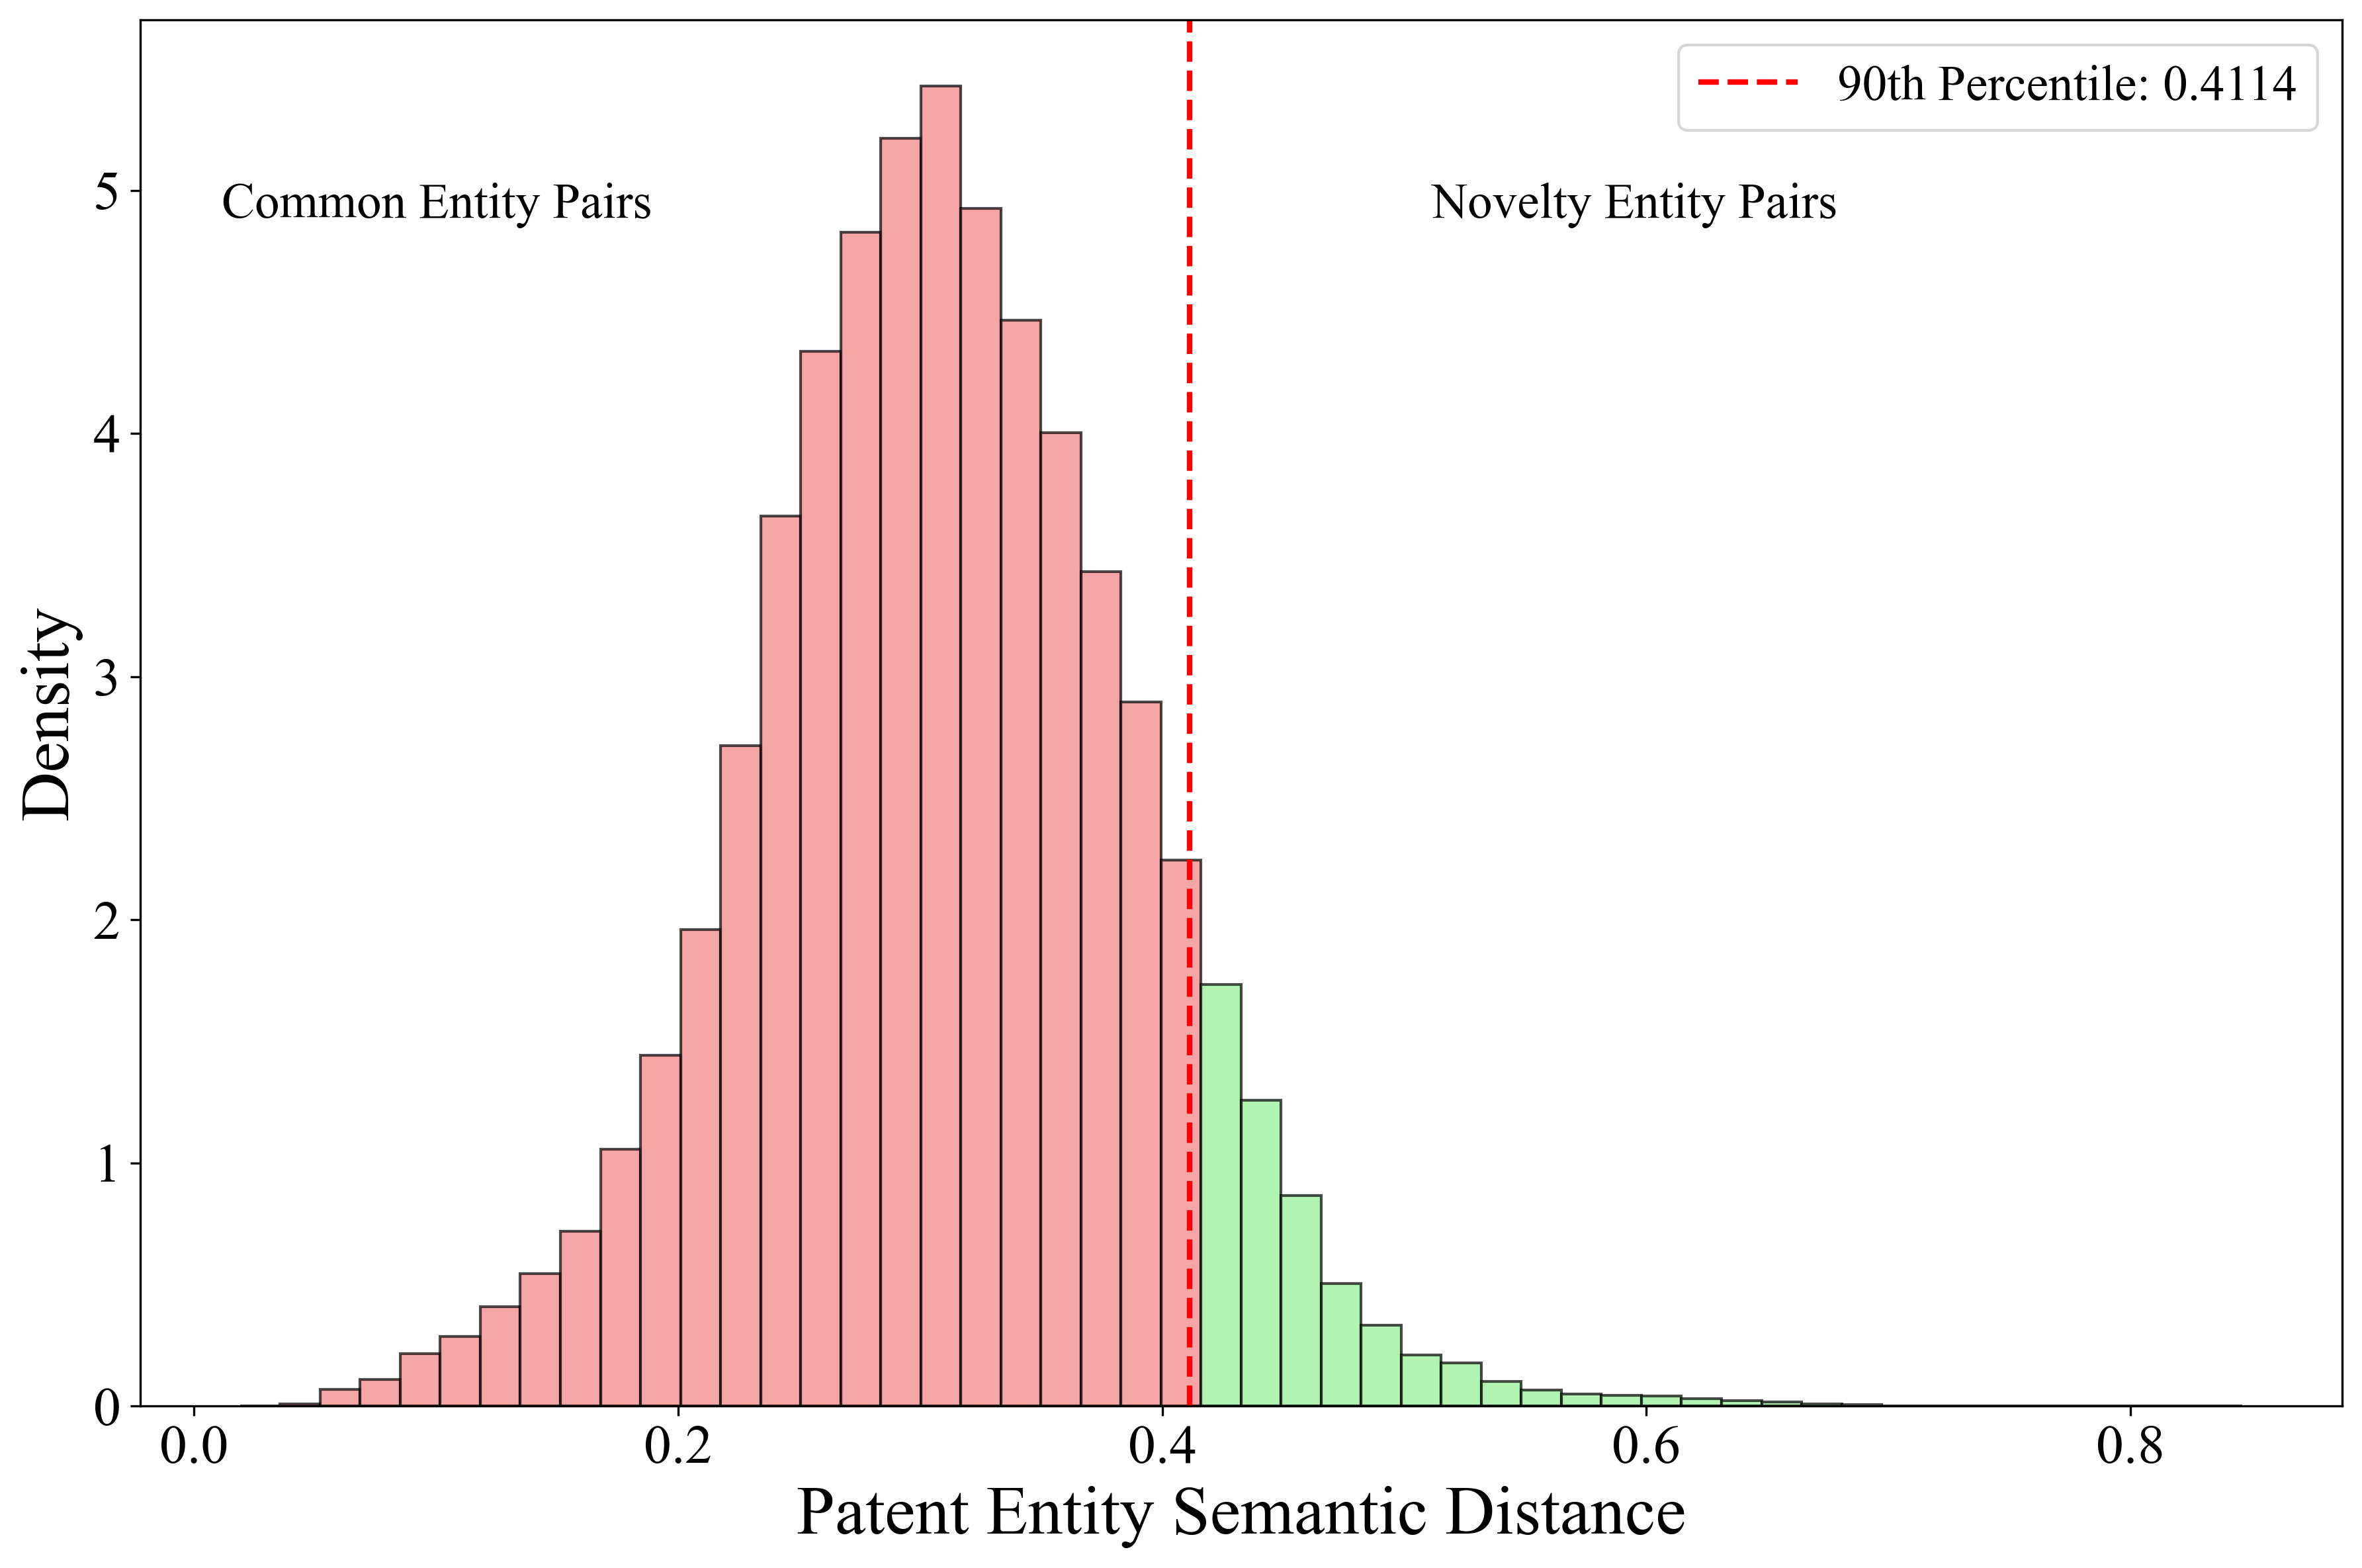

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=300)

# 计算直方图
n, bins, patches = plt.hist(similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7,density=True)

# 填充左右两边不同颜色
for i in range(len(patches)):
    if bins[i] < ninetenth_percentile-0.01:
        patches[i].set_facecolor('lightcoral')  # 左侧使用 lightcoral
    else:
        patches[i].set_facecolor('lightgreen')  # 右侧使用 lightgreen

# 添加竖线表示 90th 百分位数
plt.axvline(ninetenth_percentile, color='r', linestyle='dashed', linewidth=2, label=f'90th Percentile: {ninetenth_percentile:.4f}')

plt.xlabel('Patent Entity Semantic Distance', fontsize=25)
plt.ylabel('Density', fontsize=25)

# 设置字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 添加文本标签
plt.text(x=ninetenth_percentile - 0.4, y=max(n) * 0.9, s="Common Entity Pairs", fontsize=18, color='black')
plt.text(x=ninetenth_percentile + 0.1, y=max(n) * 0.9, s="Novelty Entity Pairs", fontsize=18, color='black')

# 添加图例
plt.legend(fontsize=18)

# 显示图形
plt.tight_layout()
plt.show()

In [9]:
# 初始化存储每个专利的新颖程度和年份
patent_novelty_scores = {}

for patent_id, similarities in patent_entity_combinations_probabilities.items():
    # 获取该专利的申请年份
    patent_year = patent_affiliation_entity.get(patent_id, {}).get('year', None)

    # 如果没有找到年份，跳过该专利
    if patent_year is None:
        continue
    
    # 计算相似度低于 10 分位数的数量
    low_similarity_count = sum(1 for sim in similarities if sim > ninetenth_percentile)
    
    # 计算低于 10 分位数的比例
    novelty_score = low_similarity_count / len(similarities) if similarities else 0
    
    # 存储新颖程度及年份
    patent_novelty_scores[patent_id] = {
        'novelty_score': novelty_score,
        'year': patent_year
    }

In [10]:
# 将 patent_similarity_dict 转换为 DataFrame
df = pd.DataFrame.from_dict(patent_novelty_scores, orient='index').reset_index()
df.rename(columns={'index': 'Patent Number'}, inplace=True)

In [11]:
df_IPC = pd.read_excel('./patent/America_patent_result.xlsx')
# 将 DataFrame 转换为字典
patent_IPC_num_dict = df_IPC.set_index('Patent Number')['IPC_num'].to_dict()
df = df.dropna()
df = df.merge(df_IPC,on='Patent Number',how='left')

In [12]:
df['Cooperation type'] = df['Patent Number'].map(lambda pid: patent_affiliation_entity[pid].get('Cooperation type', 'other'))
df = df[df['Cooperation type'] != 'other']
df

,Patent Number,novelty_score,year,five years citations,IPC_num,family size,inventors_num,institutions_num,Cooperation type
0,US20230139628A1,0.163077,2022,0,4,2.0,4,1,industry
1,US11842038B1,0.106757,2022,0,1,1.0,8,1,industry
2,US20230135335A1,0.085897,2022,0,2,3.0,1,1,industry
3,US20230146519A1,0.392857,2022,0,1,2.0,3,1,industry
5,US20230214584A1,0.059701,2022,0,1,3.0,10,1,industry
...,...,...,...,...,...,...,...,...,...
25180,US11294752B2,0.143939,2019,0,3,1.0,4,1,industry
25181,US11322139B2,0.159574,2019,0,4,2.0,3,1,industry
25182,US20220222442A1,0.333333,2019,0,2,3.0,3,1,industry
25183,US11392838B2,0.222222,2019,0,2,4.0,3,1,industry


In [13]:
df['institution_type'] = pd.Categorical(df['Cooperation type'], categories=['industry', 'academic', 'cooperation'], ordered=False)
df = pd.get_dummies(df, columns=['institution_type'], drop_first=True)  # 以 'industry' 作为基准组

In [14]:
df

,Patent Number,novelty_score,year,five years citations,IPC_num,family size,inventors_num,institutions_num,Cooperation type,institution_type_academic,institution_type_cooperation
0,US20230139628A1,0.163077,2022,0,4,2.0,4,1,industry,False,False
1,US11842038B1,0.106757,2022,0,1,1.0,8,1,industry,False,False
2,US20230135335A1,0.085897,2022,0,2,3.0,1,1,industry,False,False
3,US20230146519A1,0.392857,2022,0,1,2.0,3,1,industry,False,False
5,US20230214584A1,0.059701,2022,0,1,3.0,10,1,industry,False,False
...,...,...,...,...,...,...,...,...,...,...,...
25180,US11294752B2,0.143939,2019,0,3,1.0,4,1,industry,False,False
25181,US11322139B2,0.159574,2019,0,4,2.0,3,1,industry,False,False
25182,US20220222442A1,0.333333,2019,0,2,3.0,3,1,industry,False,False
25183,US11392838B2,0.222222,2019,0,2,4.0,3,1,industry,False,False


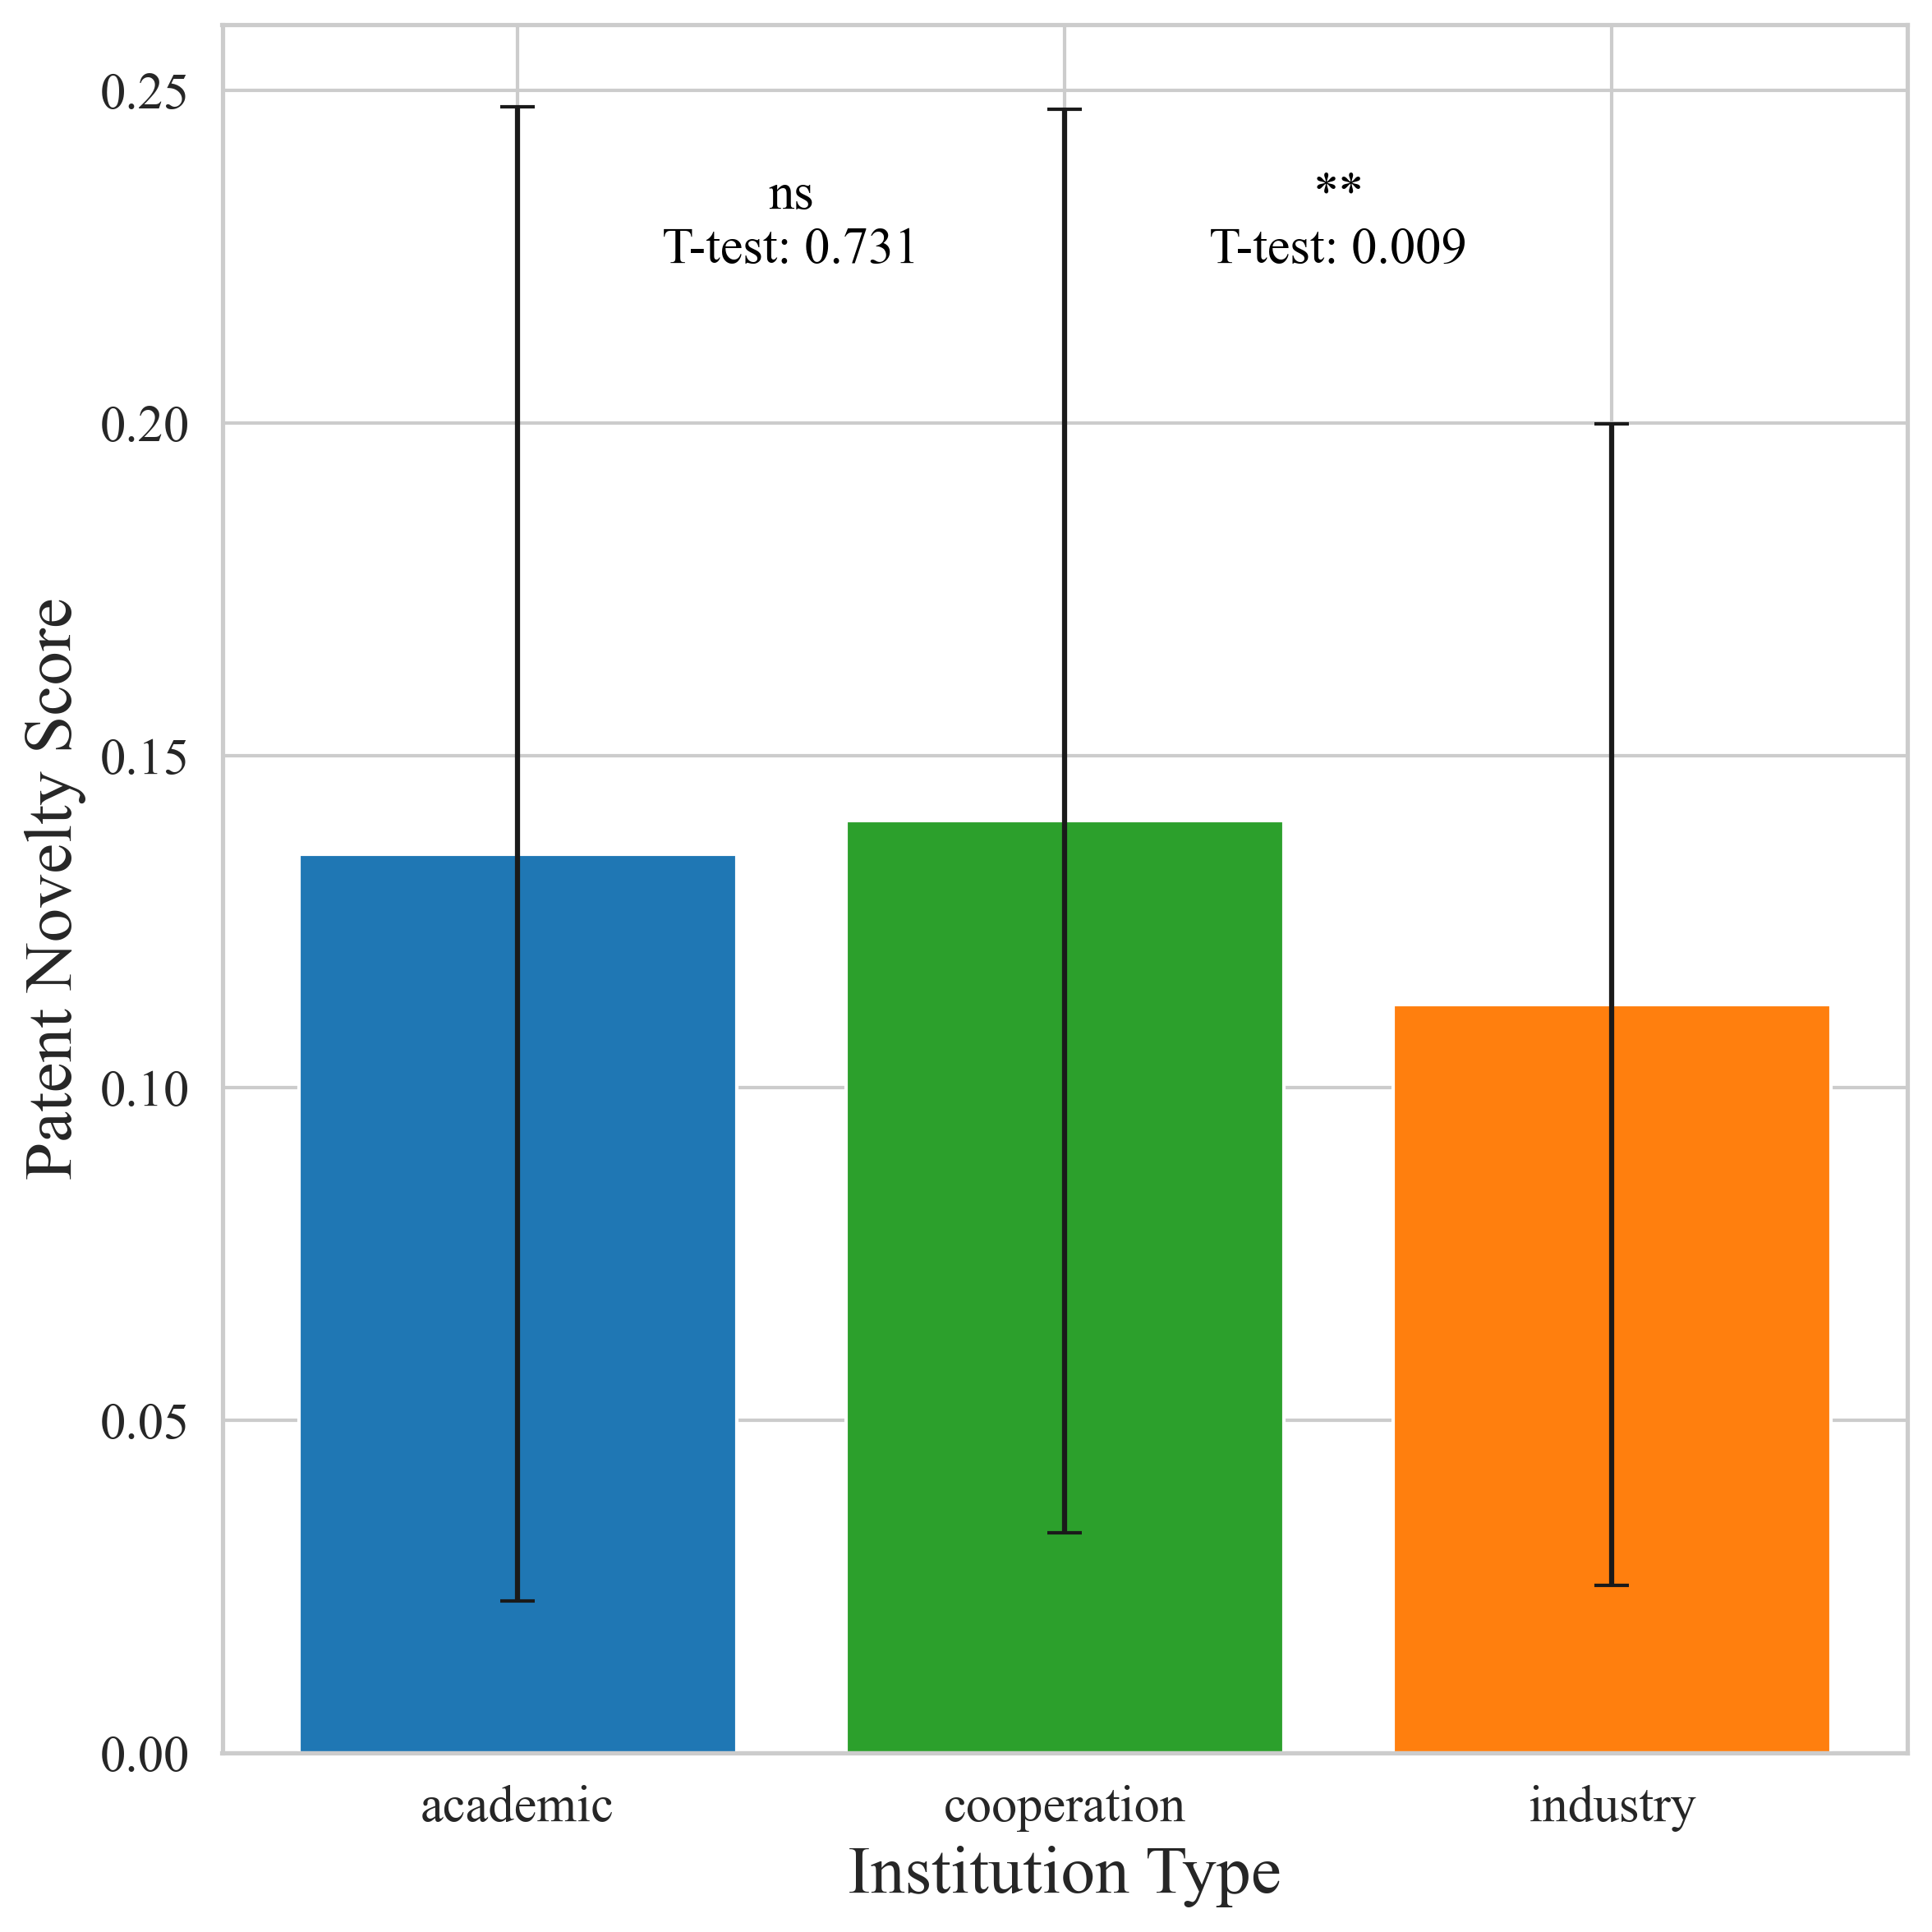

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from cycler import cycler  # 导入cycler函数

# 假设 df 是您已经处理的数据框

avg_novelty_scores = df.groupby('Cooperation type')['novelty_score'].agg(['mean', 'std']).reset_index()

# 创建一个绘图风格
sns.set(style="whitegrid", font="Times New Roman")

# 设置自定义颜色配色方案
palette = ['#1f77b4', '#2ca02c','#ff7f0e']

# 创建柱状图并添加误差线
plt.figure(figsize=(8, 8), dpi=300)

# 绘制柱状图并添加误差线
bars = plt.bar(avg_novelty_scores['Cooperation type'], avg_novelty_scores['mean'], 
               yerr=avg_novelty_scores['std'], color=palette, capsize=5, label='Average Novelty Score')

# 添加显著性星号
# 比较第一组和第二组
group_1 = df[df['Cooperation type'] == avg_novelty_scores['Cooperation type'][0]]['novelty_score']
group_2 = df[df['Cooperation type'] == avg_novelty_scores['Cooperation type'][1]]['novelty_score']
t_stat_1_2, p_val_1_2 = stats.ttest_ind(group_1, group_2)

# 比较第二组和第三组
group_3 = df[df['Cooperation type'] == avg_novelty_scores['Cooperation type'][2]]['novelty_score']
t_stat_2_3, p_val_2_3 = stats.ttest_ind(group_2, group_3)

# 根据 p 值添加星号
def get_significance(p_val):
    if p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

# 获取y轴的最大值，留白空间
y_max = max(avg_novelty_scores['mean'] + avg_novelty_scores['std'])  

# 在柱状图之间添加显著性标注
# 第一组和第二组之间
plt.text(0.5, y_max-0.025, f'{get_significance(p_val_1_2)}\nT-test: {p_val_1_2:.3f}', ha='center', va='bottom', fontsize=15, color='black')
# 第二组和第三组之间
plt.text(1.5, y_max-0.025, f'{get_significance(p_val_2_3)}\nT-test: {p_val_2_3:.3f}', ha='center', va='bottom', fontsize=15, color='black')

plt.xlabel('Institution Type', fontsize=20)
plt.ylabel('Patent Novelty Score', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

In [16]:
# 按年份计算 novelty_score_y 的前 10%
df['novelty_score_10'] = df.groupby('year')['novelty_score'].transform(lambda y: (y >= y.quantile(0.9)).astype(int))

In [17]:
df.to_excel('./result/patent_novelty_stata.xlsx',index=False)

<Figure size 3600x3600 with 0 Axes>

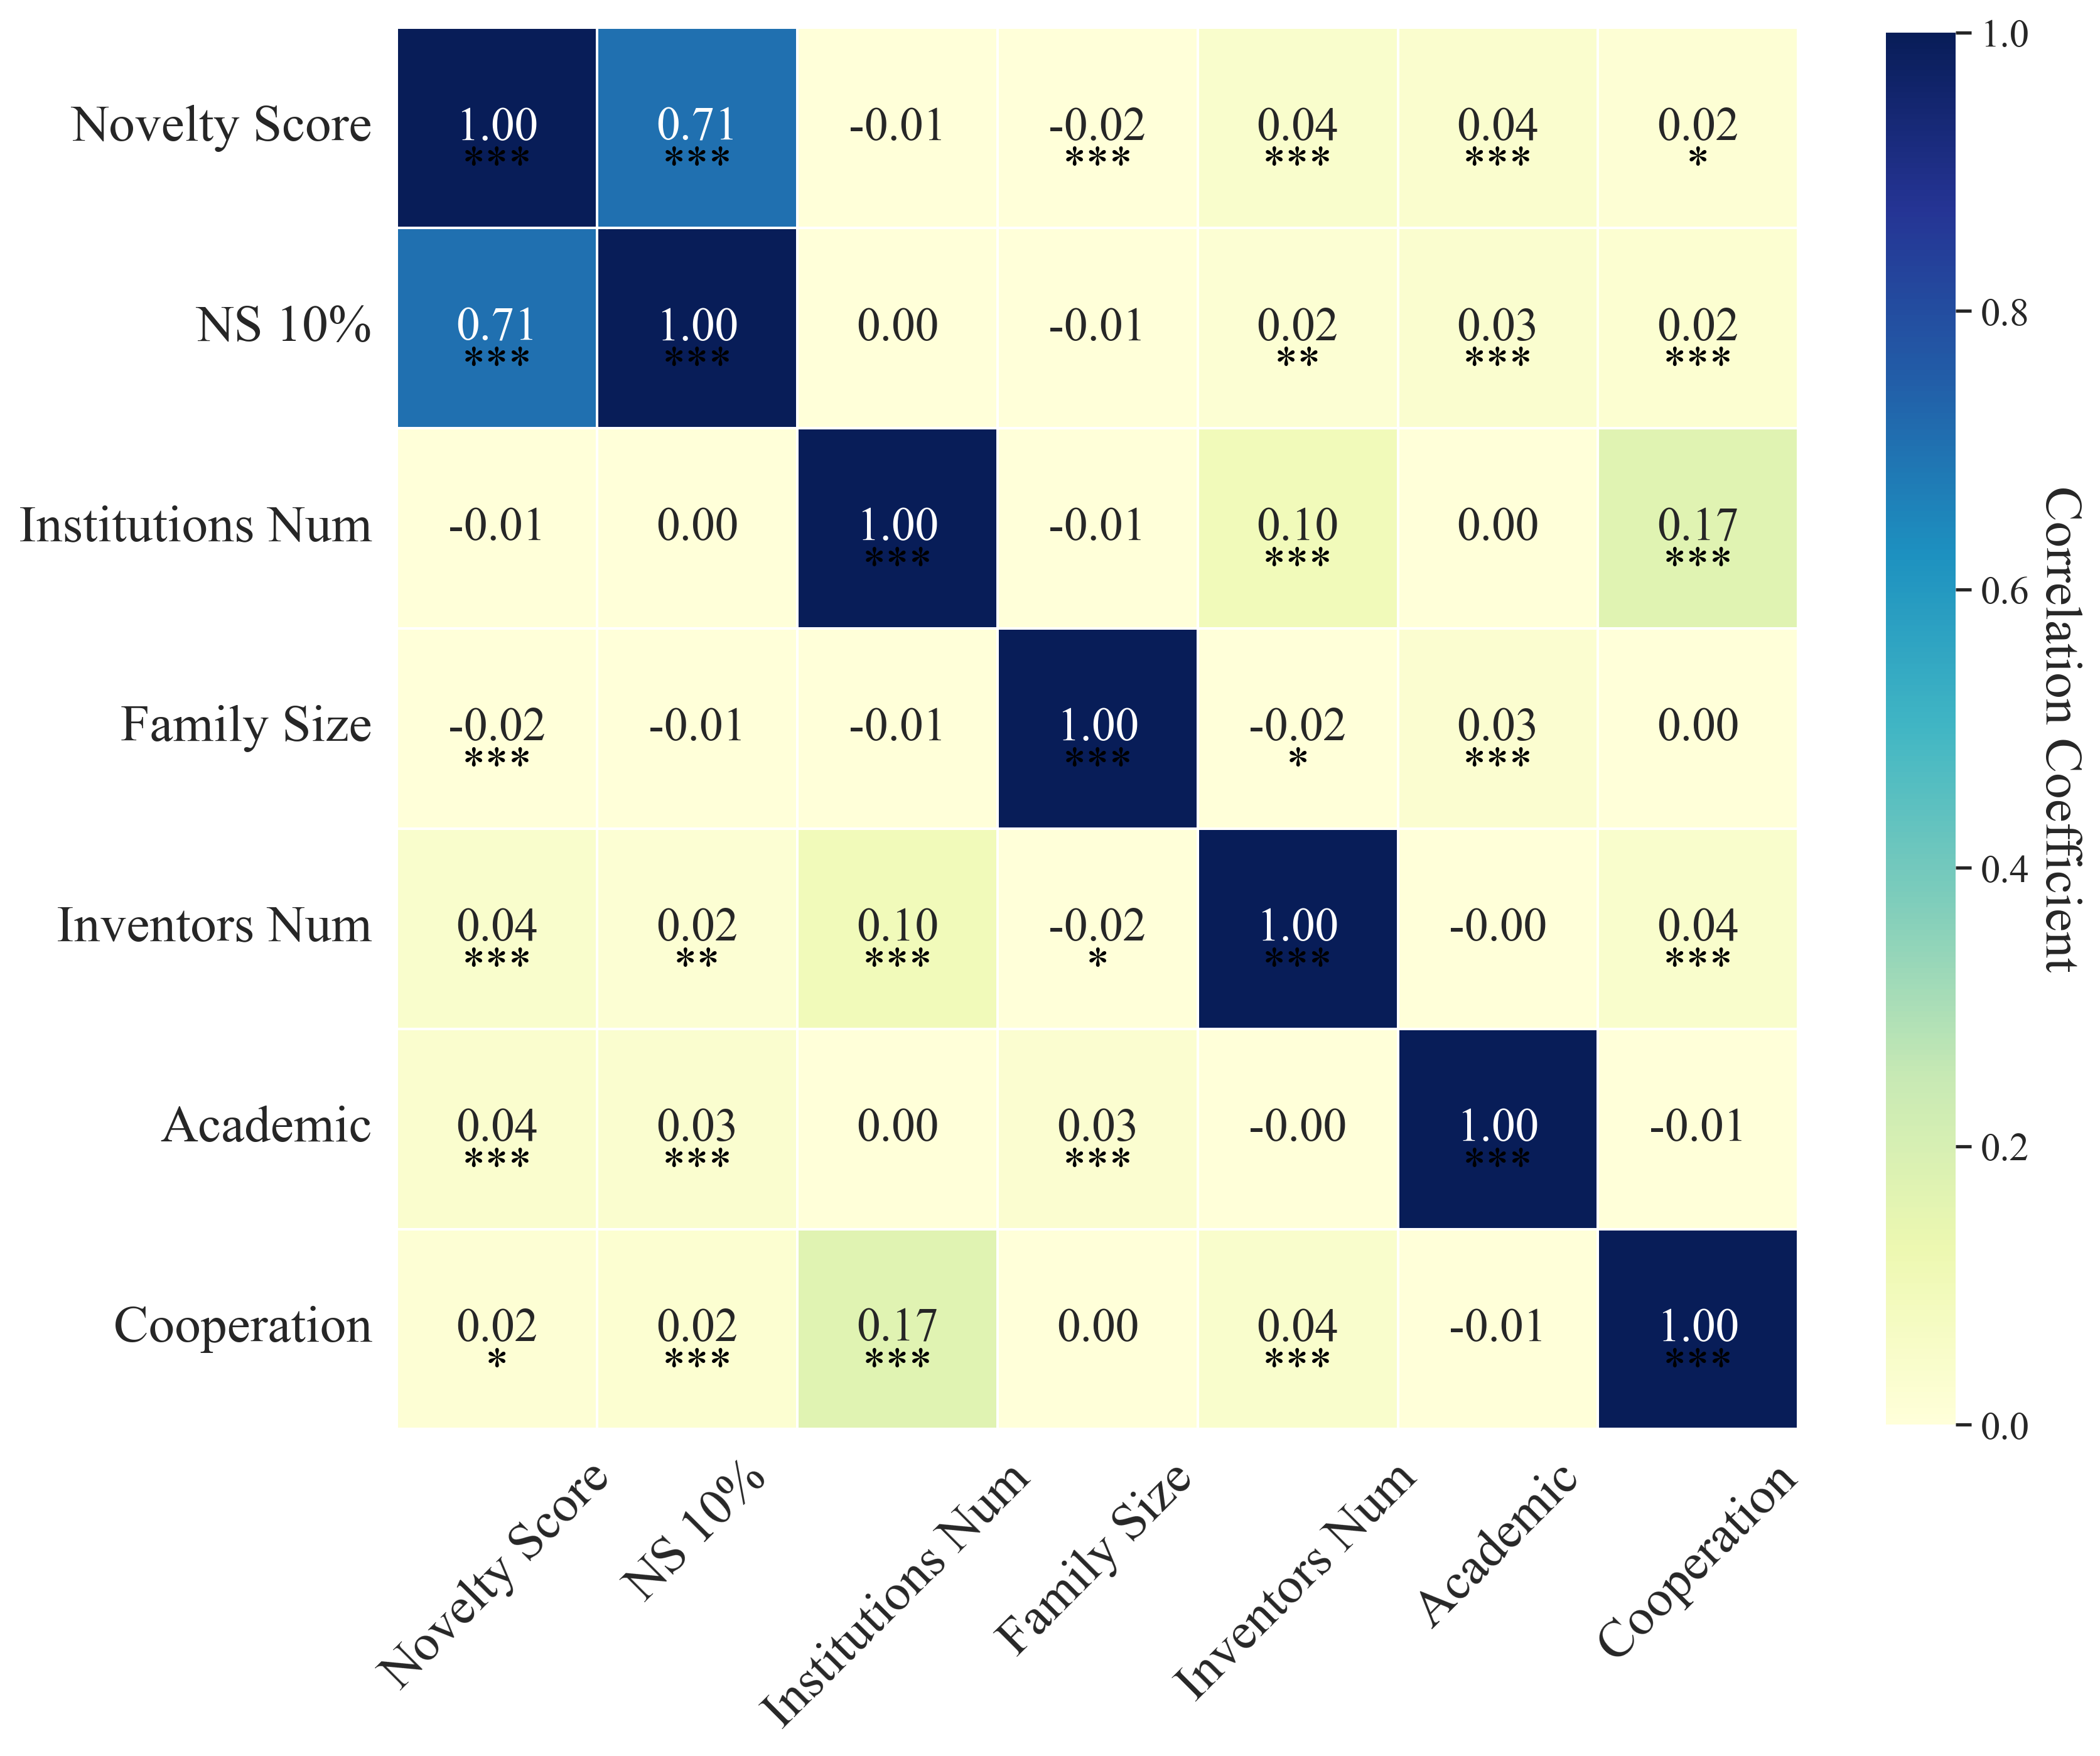

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

df['institution_type_academic'] = df['institution_type_academic'].astype(int)
df['institution_type_cooperation'] = df['institution_type_cooperation'].astype(int)

# 删除包含 NaN 的行
df_cleaned = df[['novelty_score', 'novelty_score_10', 'institutions_num', 
                 'family size', 'inventors_num', 'institution_type_academic', 'institution_type_cooperation']].dropna(subset=['family size'])

# 计算相关性矩阵
correlation_matrix = df_cleaned.corr()

# 计算 p 值矩阵
p_values = np.ones_like(correlation_matrix, dtype=float)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        _, p_values[i, j] = pearsonr(df_cleaned.iloc[:, i], df_cleaned.iloc[:, j])

# 将 p 值转换为星号表示
p_star_matrix = np.full_like(correlation_matrix, '', dtype=object)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        p_val = p_values[i, j]
        if p_val < 0.001:
            p_star_matrix[i, j] = '***'
        elif p_val < 0.01:
            p_star_matrix[i, j] = '**'
        elif p_val < 0.05:
            p_star_matrix[i, j] = '*'
        else:
            p_star_matrix[i, j] = 'n.s.'

# 创建热图
plt.figure(figsize=(12, 12),dpi=300)

# 自定义横纵坐标名
column_names = ['Novelty Score', 'NS 10%', 'Institutions Num', 'Family Size', 'Inventors Num', 'Academic', 'Cooperation']

# 创建热图
plt.figure(figsize=(12, 12), dpi=300)

# 绘制相关性热图（只显示相关性系数）
ax = sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', square=True, fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8}, annot_kws={'size': 18},
            xticklabels=column_names, yticklabels=column_names, vmin=0, vmax=1.0)

# 在相关性值下方显示星号矩阵
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if p_star_matrix[i, j] != 'n.s.':  # 只有显著性星号才显示
            plt.text(j + 0.5, i + 0.7, p_star_matrix[i, j], ha='center', va='center', fontsize=18, color='black')


# 添加相关系数色块条标签
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)  # 这里设置字体大小为10，
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, size=20)


# 旋转横坐标标签 45°
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=0,fontsize=20)

# 显示图像
plt.show()

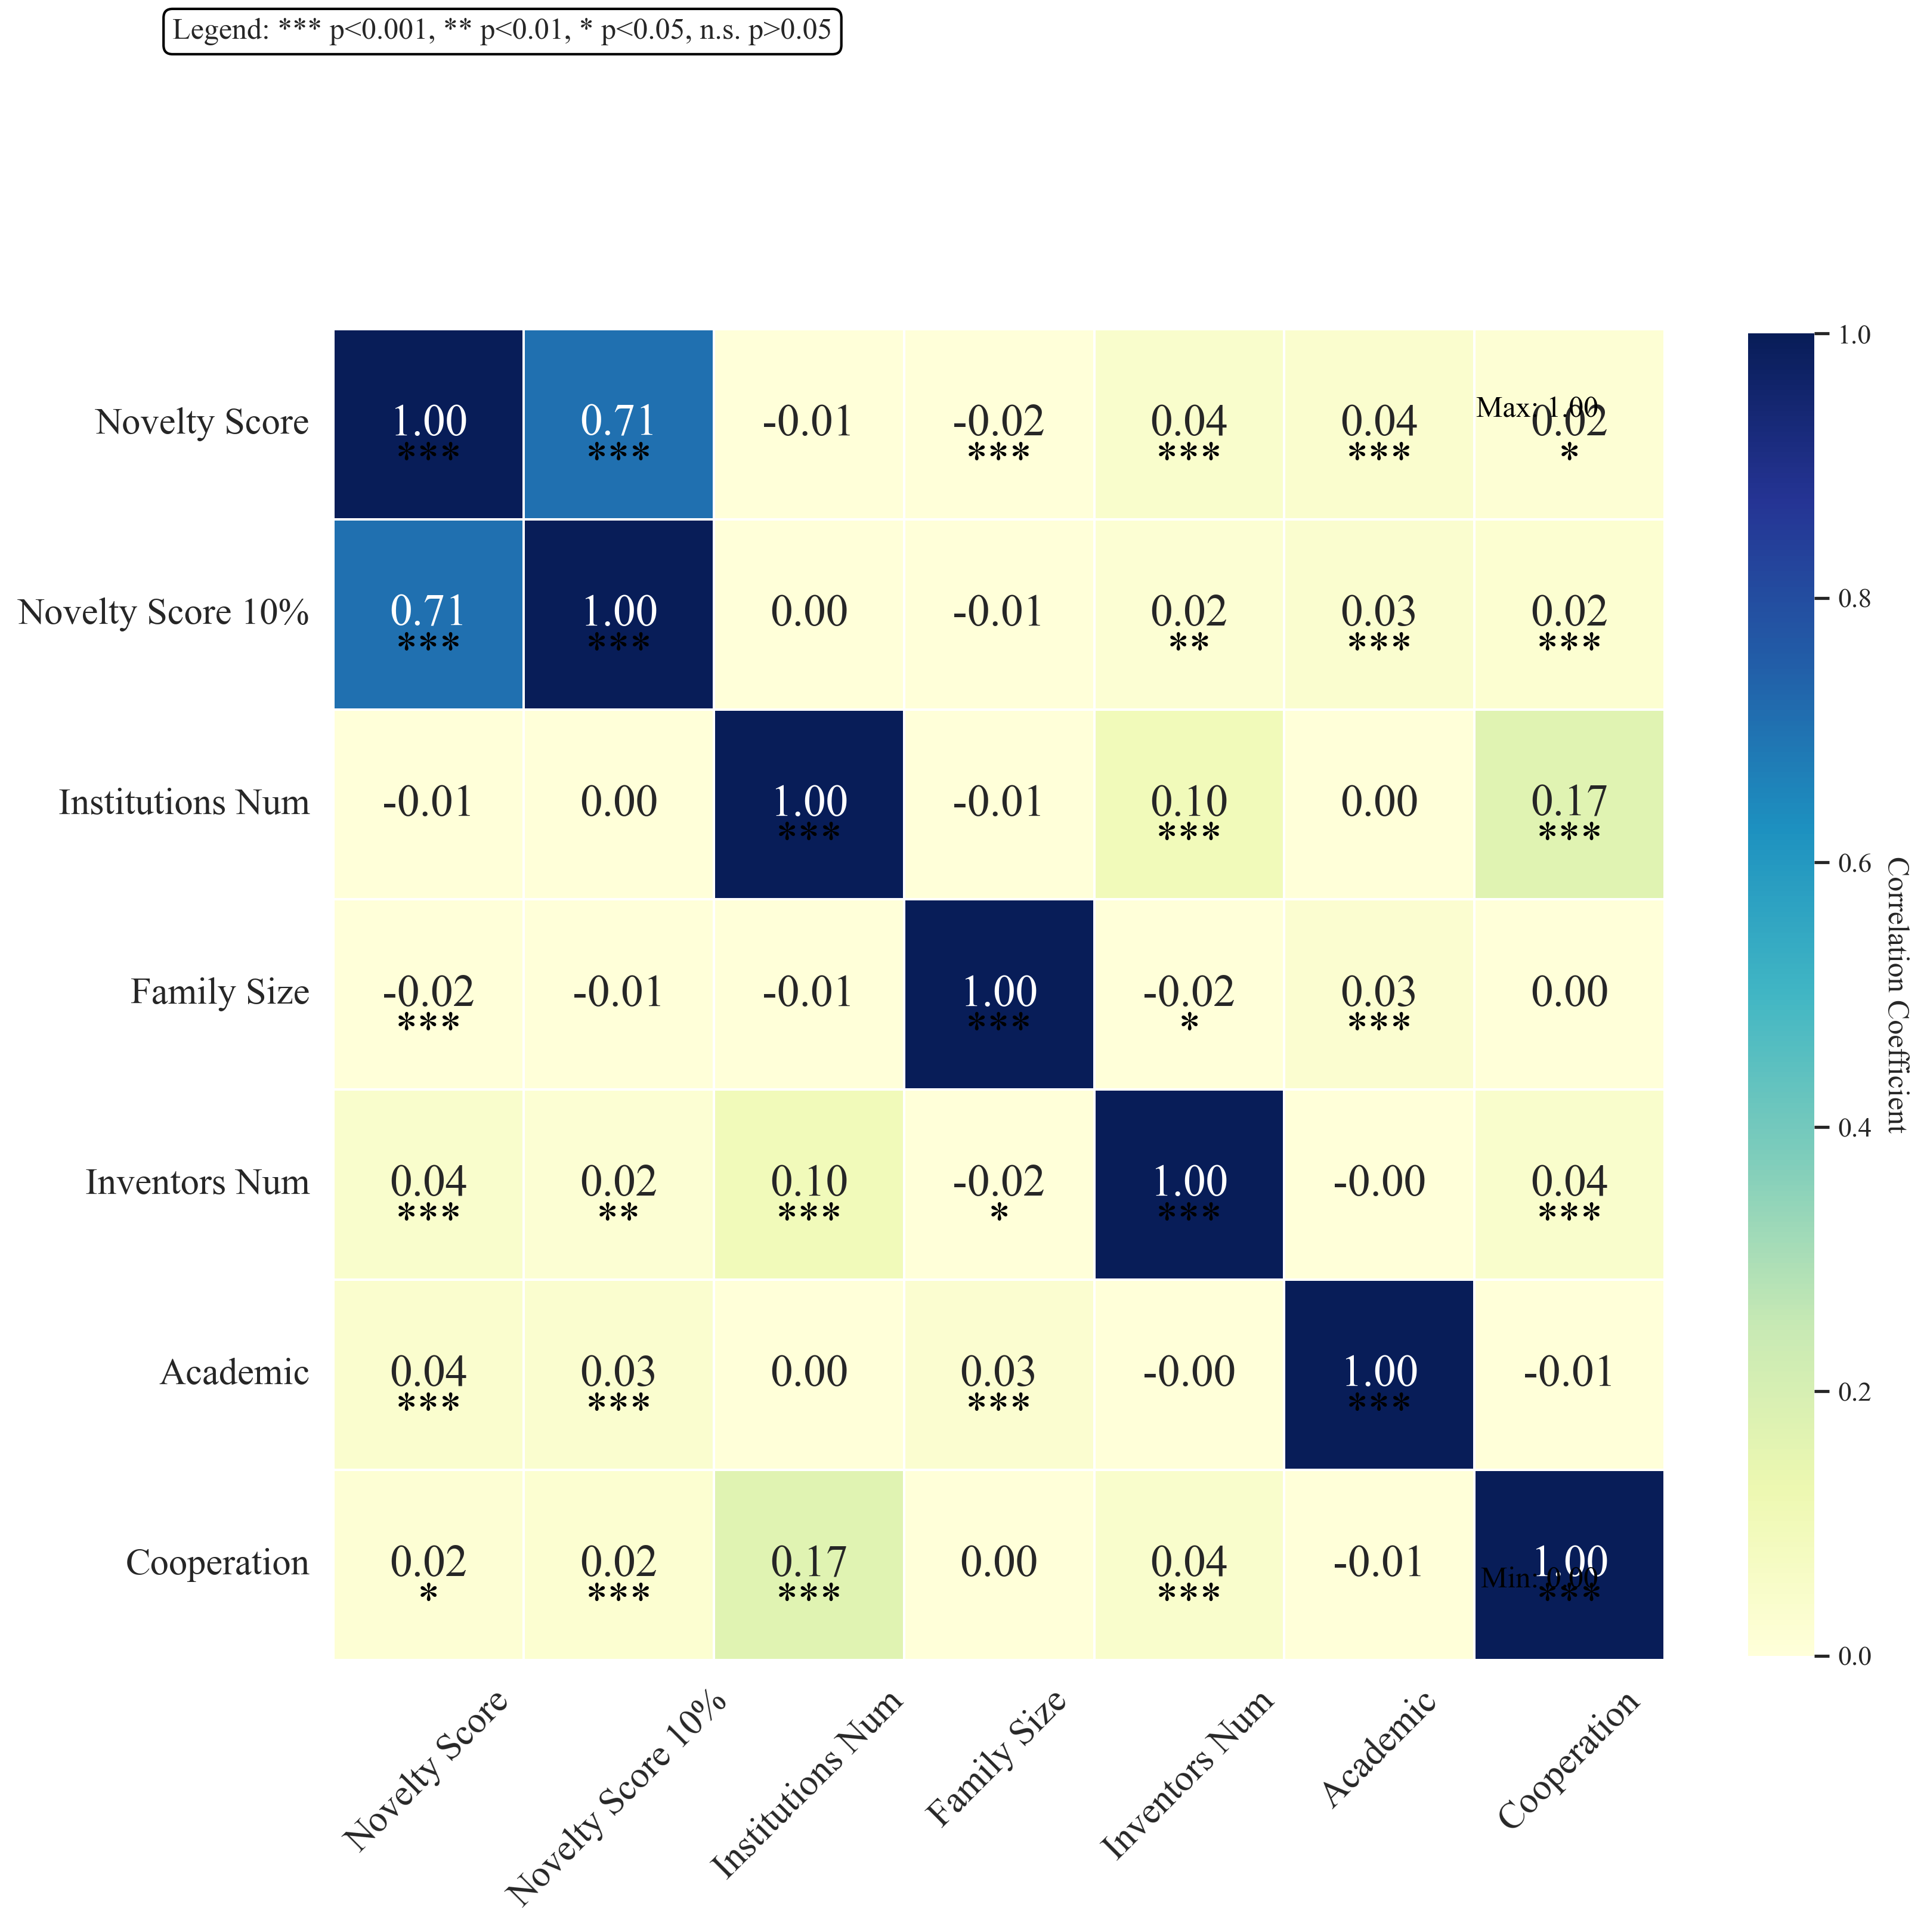

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# 删除包含 NaN 的行
df_cleaned = df[['novelty_score', 'novelty_score_10', 'institutions_num', 
                 'family size', 'inventors_num', 'institution_type_academic', 'institution_type_cooperation']].dropna(subset=['family size'])

# 计算相关性矩阵
correlation_matrix = df_cleaned.corr()

# 计算 p 值矩阵
p_values = np.ones_like(correlation_matrix, dtype=float)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        _, p_values[i, j] = pearsonr(df_cleaned.iloc[:, i], df_cleaned.iloc[:, j])

# 将 p 值转换为星号表示
p_star_matrix = np.full_like(correlation_matrix, '', dtype=object)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        p_val = p_values[i, j]
        if p_val < 0.001:
            p_star_matrix[i, j] = '***'
        elif p_val < 0.01:
            p_star_matrix[i, j] = '**'
        elif p_val < 0.05:
            p_star_matrix[i, j] = '*'
        else:
            p_star_matrix[i, j] = 'n.s.'

# 创建热图
plt.figure(figsize=(12, 12), dpi=300)

# 自定义横纵坐标名
column_names = ['Novelty Score', 'Novelty Score 10%', 'Institutions Num', 'Family Size', 'Inventors Num', 'Academic', 'Cooperation']

# 绘制相关性热图（只显示相关性系数）
ax = sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', square=True, fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8}, annot_kws={'size': 18},
                xticklabels=column_names, yticklabels=column_names, vmin=0, vmax=1.0)

# 在相关性值下方显示星号矩阵
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if p_star_matrix[i, j] != 'n.s.':  # 只有显著性星号才显示
            plt.text(j + 0.5, i + 0.7, p_star_matrix[i, j], ha='center', va='center', fontsize=18, color='black')

# 旋转横坐标标签 45°
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=0, fontsize=15)

# 标识最大和最小值
max_corr = correlation_matrix.abs().unstack().max()
min_corr = correlation_matrix.abs().unstack().min()
ax.text(0.95, 0.95, f'Max: {max_corr:.2f}', transform=ax.transAxes, va='top', ha='right', fontsize=12, color='black')
ax.text(0.95, 0.05, f'Min: {min_corr:.2f}', transform=ax.transAxes, va='bottom', ha='right', fontsize=12, color='black')

# 添加图例
plt.figtext(0.05, 0.95, 'Legend: *** p<0.001, ** p<0.01, * p<0.05, n.s. p>0.05', ha='left', va='top', fontsize=12, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

# 添加相关系数色块条标签
cbar = ax.collections[0].colorbar
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15, size=12)

# 显示图像
plt.show()